<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>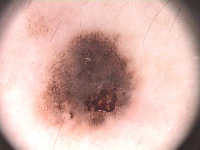</td><td>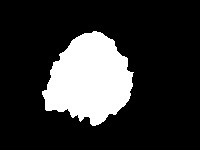</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

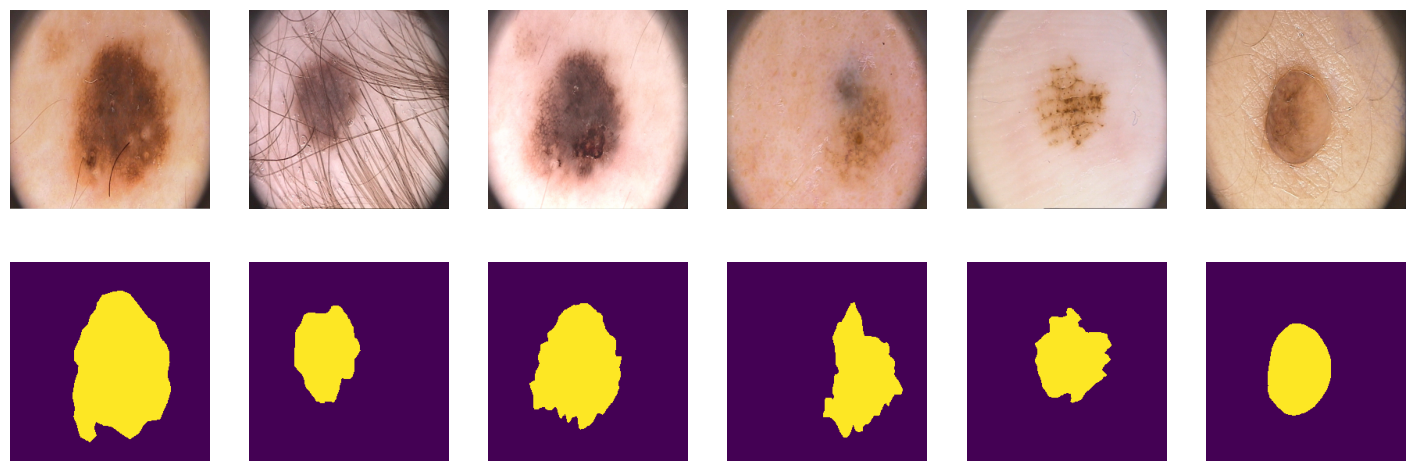

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:



<!-- <p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p> -->

<img src="./img/example.png">

In [ ]:
# !pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**


\begin{align*}
& y \cdot \bigl(-\log(\sigma(\hat{y}))\bigr) + (1 - y) \cdot \bigl(-\log(1 - \sigma(\hat{y}))\bigr) \\
=&\; y \cdot \left(-\log\left(\frac{1}{1 + e^{-\hat{y}}}\right)\right) + (1 - y) \cdot \left(-\log\left(\frac{e^{-\hat{y}}}{1 + e^{-\hat{y}}}\right)\right) \\
=&\; y \cdot \log\left(1 + e^{-\hat{y}}\right) + (1 - y) \cdot \left(-\log\left(e^{-\hat{y}}\right) + \log\left(1 + e^{-\hat{y}}\right)\right) \\
=&\; y \cdot \log\left(1 + e^{-\hat{y}}\right) + (1 - y) \cdot \left(\hat{y} + \log\left(1 + e^{-\hat{y}}\right)\right) \\
=&\; (1 - y) \cdot \hat{y} + \log\left(1 + e^{-\hat{y}}\right) \\
=&\; \hat{y} - \hat{y} \cdot y + \log\left(1 + e^{-\hat{y}}\right)
\end{align*}



Такж стоит отметить, что при $\hat{y} < 0$, чтобы избежать переполнения в $exp(-\hat{y})$, переформулируем вышеприведенное:


\begin{align*}
\hat{y} - \hat{y} \cdot y + \log\left(1 + e^{-\hat{y}}\right)
&= \log\left(e^{\hat{y}}\right) - \hat{y} \cdot y + \log\left(1 + e^{-\hat{y}}\right) \\
&= - \hat{y} \cdot y + \log\left(1 + e^{\hat{y}}\right)
\end{align*}


Следовательно, для обеспечения стабильности и избежания переполнения, реализация использует эту эквивалентную формулировку:

$$ max(\hat{y}, 0) - \hat{y} \cdot y + \log\left(1 + \exp\bigl(-|\hat{y}|\bigr)\right) $$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_true(y_pred, y_real):
    """
    Вычисляет бинарную кросс-энтропию по формуле:
    max(y_pred, 0) - y_pred * y_real + log(1 + exp(-abs(y_pred)))

    Args:
        y_pred (torch.Tensor): Логиты предсказаний (неприменённая сигмоида).
        y_real (torch.Tensor): Истинные метки (0 или 1), того же размера, что и y_pred.

    Returns:
        torch.Tensor: Значение потерь для каждого элемента.
    """
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).sum()


def bce_loss(y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
    """
    Вычисляет бинарную кросс-энтропию по формуле:
    max(y_pred, 0) - y_pred * y_real + log(1 + exp(-abs(y_pred)))

    Args:
        y_pred (torch.Tensor): Логиты предсказаний (неприменённая сигмоида).
        y_real (torch.Tensor): Истинные метки (0 или 1), того же размера, что и y_pred.

    Returns:
        torch.Tensor: Значение потерь для каждого элемента.
    """
    max_term = torch.clamp(y_pred, min=0)
    log_exp_term = torch.log1p(torch.exp(-torch.abs(y_pred)))  # log(1 + exp(-|y_pred|))

    loss = max_term - y_pred * y_real + log_exp_term
    return loss.sum()

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')

BCE loss from scratch bce_loss = 6.041408061981201
BCE loss честно посчитанный = 6.041408538818359
BCE loss from torch bce_torch = 6.041407585144043
BCE loss from torch with logits bce_torch = 6.041408061981201


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 17.217479705810547
BCE loss честно посчитанный = 17.217479705810547
BCE loss from torch bce_torch = 17.217479705810547
BCE loss from torch with logits bce_torch = 17.217479705810547


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
# !gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

In [ ]:
# path_to_dummy_samples = '/content/for_asserts'
path_to_dummy_samples = '.'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

C:\Temp\ipykernel_12500\1070577337.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
C:\Temp\i

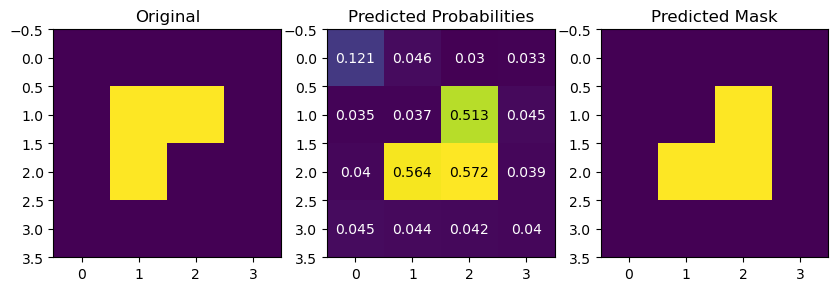

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

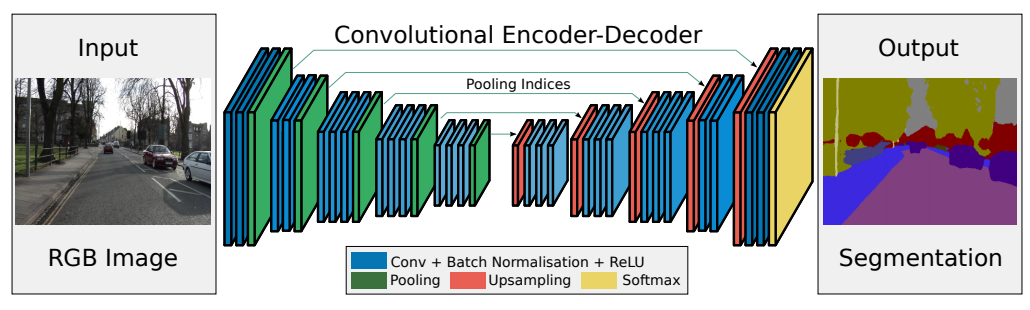

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm.notebook import tqdm
import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, with_sigmoid=False):
        """
        SegNet архитектура для задач сегментации изображений

        Args:
            in_channels (int): Количество входных каналов (обычно 3 для RGB)
            out_channels (int): Количество выходных каналов (обычно 1 для бинарной сегментации)
            with_sigmoid (bool): Применять ли сигмоидную активацию к выходу
        """
        super(SegNet, self).__init__()
        self.with_sigmoid = with_sigmoid

        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.enc_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec_conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Encoder с сохранением индексов для unpooling
        # stage 1
        x1 = self.enc_conv1(x)
        x1_size = x1.size()
        x1_pool, indices1 = F.max_pool2d(x1, kernel_size=2, stride=2, return_indices=True)

        # stage 2
        x2 = self.enc_conv2(x1_pool)
        x2_size = x2.size()
        x2_pool, indices2 = F.max_pool2d(x2, kernel_size=2, stride=2, return_indices=True)

        # stage 3
        x3 = self.enc_conv3(x2_pool)
        x3_size = x3.size()
        x3_pool, indices3 = F.max_pool2d(x3, kernel_size=2, stride=2, return_indices=True)

        # stage 4
        x4 = self.enc_conv4(x3_pool)
        x4_size = x4.size()
        x4_pool, indices4 = F.max_pool2d(x4, kernel_size=2, stride=2, return_indices=True)

        # stage 5
        x5 = self.enc_conv5(x4_pool)
        x5_size = x5.size()
        x5_pool, indices5 = F.max_pool2d(x5, kernel_size=2, stride=2, return_indices=True)

        # Decoder с использованием max unpooling
        # stage 5
        x5_unpool = F.max_unpool2d(x5_pool, indices5, kernel_size=2, stride=2, output_size=x5_size)
        y5 = self.dec_conv5(x5_unpool)

        # stage 4
        x4_unpool = F.max_unpool2d(y5, indices4, kernel_size=2, stride=2, output_size=x4_size)
        y4 = self.dec_conv4(x4_unpool)

        # stage 3
        x3_unpool = F.max_unpool2d(y4, indices3, kernel_size=2, stride=2, output_size=x3_size)
        y3 = self.dec_conv3(x3_unpool)

        # stage 2
        x2_unpool = F.max_unpool2d(y3, indices2, kernel_size=2, stride=2, output_size=x2_size)
        y2 = self.dec_conv2(x2_unpool)

        # stage 1
        x1_unpool = F.max_unpool2d(y2, indices1, kernel_size=2, stride=2, output_size=x1_size)
        y1 = self.dec_conv1(x1_unpool)

        # Применяем сигмоиду, если с активацией
        if self.with_sigmoid:
            out = torch.sigmoid(y1)
        else:
            out = y1

        return out

In [ ]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

**ВАЖНО!**
Предложенная выше функция bce_loss является реализацией бинарной кросс-энтропии в численно стабильной форме. Изменим sum на mean для сопоставимости с nn.BCELoss. И переопределим.

In [ ]:
def bce_loss_stable(y_pred: torch.Tensor, y_real: torch.Tensor) -> torch.Tensor:
    max_term = torch.clamp(y_pred, min=0)
    log_exp_term = torch.log1p(torch.exp(-torch.abs(y_pred)))  # log(1 + exp(-|y_pred|))
    loss = max_term - y_pred * y_real + log_exp_term
    return loss.mean()

In [ ]:
# Функция для вычисления IoU (Intersection over Union)
def iou_score(outputs, targets, threshold=0.5):
    smooth = 1e-6
    # Применяем сигмоиду, если outputs - логиты
    if not outputs.max() <= 1:
        outputs = torch.sigmoid(outputs)

    # Бинаризация выходов по порогу
    outputs = (outputs > threshold).float()

    # Flatten
    outputs = outputs.view(-1)
    targets = targets.view(-1)

    # Вычисление IoU
    intersection = (outputs * targets).sum()
    union = outputs.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou.item()

In [ ]:
# Функция для обучения модели
def train(w_name, model, train_dataloader, valid_dataloader, num_epochs, device, loss_fn, optimizer):
    # Инициализация списков для хранения времени и потерь
    times = []
    losses = []

    best_iou = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        # Обучение на тренировочном наборе
        for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            masks = masks.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)

            # Вычисление функции потерь
            loss = loss_fn(outputs, masks)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Вычисление среднего значения потерь для эпохи
        epoch_loss = running_loss / len(train_dataloader)
        losses.append(epoch_loss)

        # Вычисление времени выполнения эпохи
        epoch_time = time.time() - start_time
        times.append(epoch_time)

        # Валидация
        valid_iou = test(model, valid_dataloader, device)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Loss: {epoch_loss:.4f}, "
              f"IoU: {valid_iou:.4f}, "
              f"Time: {epoch_time:.2f}s")

        # Сохранение лучшей модели
        if valid_iou > best_iou:
            best_iou = valid_iou
            torch.save(model.state_dict(), f"./weights/{w_name}")
            print(f"Saved best model with IoU: {best_iou:.4f}")

    return times, losses

In [ ]:
def test(model, dataloader, device):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Прямой проход
            outputs = model(images)

            # Вычисление IoU
            batch_iou = iou_score(outputs, masks)
            iou_scores.append(batch_iou)

    # Вычисление среднего IoU
    mean_iou = np.mean(iou_scores)

    return mean_iou

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
result_dict = {}
max_epochs = 30

In [ ]:
optim = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
seg_bce_name = "best_segnet_bce_model.pth"
seg_bce_times, seg_bce_losses = train(seg_bce_name, segnet_model, train_dataloader, valid_dataloader, max_epochs, device, bce_loss_stable, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.6643, IoU: 0.0000, Time: 4.73s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.4095, IoU: 0.0000, Time: 3.92s
Saved best model with IoU: 0.0000


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.2801, IoU: 0.0000, Time: 3.92s


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.2505, IoU: 0.0000, Time: 4.04s


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.2641, IoU: 0.0899, Time: 3.94s
Saved best model with IoU: 0.0899


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.2543, IoU: 0.2631, Time: 3.97s
Saved best model with IoU: 0.2631


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.2293, IoU: 0.2144, Time: 3.99s


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.2163, IoU: 0.2806, Time: 4.01s
Saved best model with IoU: 0.2806


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.2046, IoU: 0.5636, Time: 4.06s
Saved best model with IoU: 0.5636


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.1864, IoU: 0.7684, Time: 4.05s
Saved best model with IoU: 0.7684


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.1954, IoU: 0.7877, Time: 4.09s
Saved best model with IoU: 0.7877


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.1849, IoU: 0.7546, Time: 4.11s


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.1738, IoU: 0.7198, Time: 4.15s


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.1857, IoU: 0.8129, Time: 4.14s
Saved best model with IoU: 0.8129


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.1828, IoU: 0.7792, Time: 4.17s


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.2097, IoU: 0.8045, Time: 4.18s


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.1880, IoU: 0.6866, Time: 4.25s


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.1860, IoU: 0.8004, Time: 4.26s


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.1729, IoU: 0.7845, Time: 4.35s


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.1755, IoU: 0.8007, Time: 4.36s


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.1601, IoU: 0.7737, Time: 4.39s


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.1608, IoU: 0.8109, Time: 4.46s


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.1666, IoU: 0.8201, Time: 4.50s
Saved best model with IoU: 0.8201


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.1935, IoU: 0.8037, Time: 4.56s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.1503, IoU: 0.7938, Time: 4.57s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.1711, IoU: 0.7792, Time: 4.52s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.1900, IoU: 0.7932, Time: 4.46s


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.1877, IoU: 0.8165, Time: 4.46s


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.1621, IoU: 0.8260, Time: 4.41s
Saved best model with IoU: 0.8260


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.1598, IoU: 0.8311, Time: 4.41s
Saved best model with IoU: 0.8311


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def print_result(model, model_name, test_data, device, test_iou):
    X_val, Y_val = next(iter(test_data))
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    model.eval()  # testing mode
    Y_hat = model(X_val).detach().cpu().numpy() # detach and put into cpu
    for k in range(6):
        plt.subplot(2, 6, k+1)
        #plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.imshow(np.transpose(X_val[k].cpu().numpy(), (1, 2, 0)), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.suptitle(f"Model: {model_name[:-10]}, IoU: {test_iou:.4f}")
    plt.show()
    print(f"{test_iou:.4f}")

In [ ]:
# Загрузка лучшей модели и тестирование
segnet_model.load_state_dict(torch.load(f"./weights/{seg_bce_name}"))

<All keys matched successfully>

In [ ]:
test_iou = test(segnet_model, test_dataloader, device)

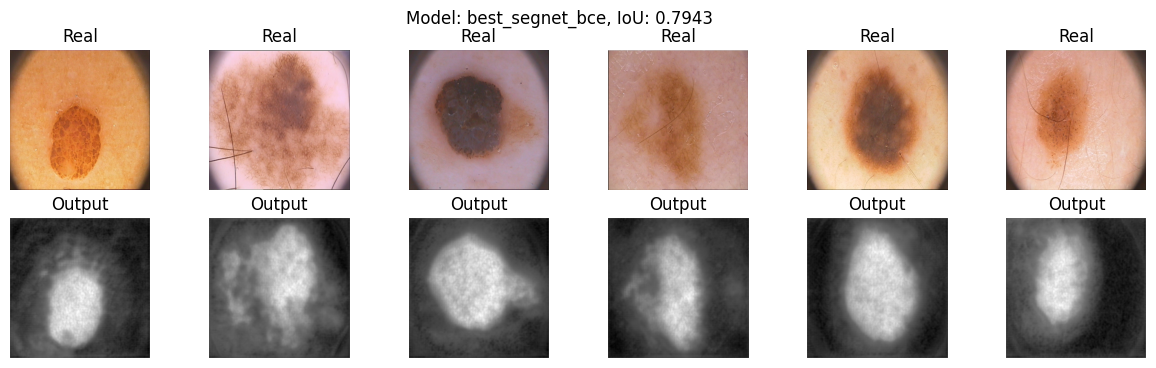

0.7943


In [ ]:
print_result(segnet_model, seg_bce_name, test_dataloader, device, test_iou)

In [ ]:
result_dict['segnet_bce'] = (test_iou, seg_bce_times, seg_bce_losses)

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, eps: float = 1e-8):

    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    preds = preds.view(-1)
    labels = labels.view(-1)

    tp = (preds * labels).sum()
    fp = (preds * (1 - labels)).sum()
    fn = ((1 - preds) * labels).sum()

    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    return dice

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1).to(device)
dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].int())

In [ ]:
dice_score(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int), threshold=0.5)

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(y_pred: torch.Tensor, y_real: torch.Tensor, smooth=1e-6) -> torch.Tensor:
    # Если в модели больше нет сигмоиды, применяем её здесь
    y_pred = torch.sigmoid(y_pred)

    # Flatten предсказания и целевые значения
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    # Вычисляем пересечение и объединение
    intersection = (y_pred * y_real).sum()
    union = y_pred.sum() + y_real.sum()

    # Вычисляем Dice коэффициент
    dice = (2.0 * intersection + smooth) / (union + smooth)

    # Преобразуем в loss (1 - dice)
    return 1.0 - dice

Проверка на корректность:

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert torch.isclose(dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']), dice_loss(dummpy_sample['logits'], dummpy_sample['labels']))

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma=2 , alpha=0.25):
    """
    Реализация Focal Loss для бинарной сегментации.

    Args:
        y_pred: Предсказания модели (логиты)
        y_real: Целевые значения (0 или 1)
        gamma: Параметр фокусировки (больше значение - больше фокус на сложных примерах)
        alpha: Весовой коэффициент для балансировки классов

    Returns:
        torch.Tensor: Значение функции потерь
    """
    # Применяем сигмоиду к логитам
    y_pred = torch.sigmoid(y_pred)

    # Вычисляем бинарную кросс-энтропию поэлементно
    bce = -y_real * torch.log(y_pred + eps) - (1 - y_real) * torch.log(1 - y_pred + eps)

    # Применяем модулирующий фактор для фокусировки
    pt = y_real * y_pred + (1 - y_real) * (1 - y_pred)
    focal_weight = (1 - pt) ** gamma

    # Применяем alpha-балансировку
    alpha_weight = y_real * alpha + (1 - y_real) * (1 - alpha)

    # Итоговая Focal Loss
    loss = alpha_weight * focal_weight * bce

    return loss.mean()

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
assert torch.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'), focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0, alpha=0.2639), atol=1e-2)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [ ]:
from scipy.ndimage import distance_transform_edt

In [ ]:
class BoundaryLoss(nn.Module):
    def __init__(self):
        super(BoundaryLoss, self).__init__()

    def forward(self, pred_probs, target):
        """
        Поддержка обоих форматов:
        - target: (B, 1, H, W) или (B, H, W)
        - pred_probs: (B, 1, H, W)
        """
        # Приводим target к (B, H, W)
        if target.dim() == 4:
            target = target.squeeze(1)  # Удаляем dimension канала если он есть

        # Проверка размеров
        B, C, H, W = pred_probs.shape
        assert target.dim() == 3, f"Target должно быть 3D после обработки, получили {target.shape}"
        assert target.shape == (B, H, W), f"Несоответствие размеров: target {target.shape}, ожидается {(B, H, W)}"

        # Конвертируем в numpy для вычисления SDF
        target_np = target.cpu().numpy().astype(np.float32)

        # Вычисляем SDF для каждого элемента батча
        sdf = np.zeros((B, 1, H, W), dtype=np.float32)
        for i in range(B):
            mask = target_np[i]
            pos_dist = distance_transform_edt(1 - mask)  # Расстояние от фона
            neg_dist = -distance_transform_edt(mask)     # Расстояние от объекта
            sdf[i, 0] = pos_dist + neg_dist

        sdf_tensor = torch.from_numpy(sdf).float().to(pred_probs.device)

        # Boundary Loss
        loss = torch.mean(sdf_tensor * pred_probs)
        return loss

In [ ]:
def tversky_loss(y_pred: torch.Tensor, y_real: torch.Tensor, alpha=0.7, beta=0.3, smooth=1e-6):
    """
    Реализация Tversky Loss для задач сегментации изображений.
    Tversky Loss - это обобщение Dice коэффициента, которое позволяет
    контролировать баланс между false positive и false negative.

    Args:
        y_pred (torch.Tensor): Предсказания модели (логиты)
        y_real (torch.Tensor): Целевые маски
        alpha (float): Вес для false negative (по умолчанию 0.7)
        beta (float): Вес для false positive (по умолчанию 0.3)
        smooth (float): Сглаживающий коэффициент для численной стабильности

    Returns:
        torch.Tensor: Значение функции потерь
    """
    # Применяем сигмоиду к предсказаниям, если они в формате логитов
    y_pred = torch.sigmoid(y_pred)

    # Приводим тензоры к плоскому виду для вычисления
    y_pred_flat = y_pred.view(-1)
    y_real_flat = y_real.view(-1)

    # Вычисляем true positive (TP)
    tp = torch.sum(y_pred_flat * y_real_flat)

    # Вычисляем false negative (FN) и false positive (FP)
    fn = torch.sum(y_real_flat * (1 - y_pred_flat))
    fp = torch.sum(y_pred_flat * (1 - y_real_flat))

    # Вычисляем Tversky индекс
    tversky_index = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)

    # Преобразуем в функцию потерь (1 - индекс)
    loss = 1 - tversky_index

    return loss


def focal_tversky_loss(y_pred: torch.Tensor, y_real: torch.Tensor, alpha=0.7, beta=0.3, gamma=1.0, smooth=1e-6):
    """
    Focal Tversky Loss для сегментации изображений.
    Добавляет фокальный компонент к Tversky Loss, что помогает фокусироваться
    на трудно классифицируемых примерах.

    Args:
        y_pred (torch.Tensor): Предсказания модели (логиты)
        y_real (torch.Tensor): Целевые маски
        alpha (float): Вес для false negative
        beta (float): Вес для false positive
        gamma (float): Фокальный параметр, усиливающий влияние трудных примеров
        smooth (float): Сглаживающий коэффициент

    Returns:
        torch.Tensor: Значение функции потерь
    """
    # Вычисляем обычный Tversky Loss
    tversky = tversky_loss(y_pred, y_real, alpha, beta, smooth)

    # Применяем фокальный компонент
    focal_tversky = torch.pow(tversky, gamma)

    return focal_tversky

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



#### SegNet: Dice Loss

In [ ]:
segnet_dice_model = SegNet().to(device)

In [ ]:
optim = torch.optim.Adam(segnet_dice_model.parameters(), lr=1e-3)
seg_dice_name = "best_segnet_dice_model.pth"
seg_dice_times, seg_dice_losses = train(seg_dice_name, segnet_dice_model, train_dataloader, valid_dataloader, max_epochs, device, dice_loss, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.5913, IoU: 0.0000, Time: 4.31s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.4926, IoU: 0.0000, Time: 4.36s


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.4097, IoU: 0.3575, Time: 4.36s
Saved best model with IoU: 0.3575


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.3549, IoU: 0.3224, Time: 4.39s


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.2927, IoU: 0.4170, Time: 4.44s
Saved best model with IoU: 0.4170


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.2549, IoU: 0.4394, Time: 4.51s
Saved best model with IoU: 0.4394


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.2251, IoU: 0.4669, Time: 4.53s
Saved best model with IoU: 0.4669


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.2014, IoU: 0.5291, Time: 4.58s
Saved best model with IoU: 0.5291


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.1662, IoU: 0.5750, Time: 4.56s
Saved best model with IoU: 0.5750


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.1744, IoU: 0.6717, Time: 4.53s
Saved best model with IoU: 0.6717


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.1552, IoU: 0.7435, Time: 4.47s
Saved best model with IoU: 0.7435


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.1432, IoU: 0.7879, Time: 4.42s
Saved best model with IoU: 0.7879


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.1363, IoU: 0.8198, Time: 4.40s
Saved best model with IoU: 0.8198


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.1354, IoU: 0.8289, Time: 4.39s
Saved best model with IoU: 0.8289


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.1357, IoU: 0.8273, Time: 4.37s


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.1567, IoU: 0.8330, Time: 4.36s
Saved best model with IoU: 0.8330


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.1570, IoU: 0.8191, Time: 4.40s


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.1492, IoU: 0.8024, Time: 4.38s


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.1380, IoU: 0.8095, Time: 4.41s


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.1305, IoU: 0.7325, Time: 4.40s


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.1265, IoU: 0.7696, Time: 4.42s


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.1295, IoU: 0.6827, Time: 4.40s


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.1311, IoU: 0.7862, Time: 4.42s


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.1318, IoU: 0.8271, Time: 4.43s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.1377, IoU: 0.8223, Time: 4.41s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.1277, IoU: 0.7764, Time: 4.45s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.1294, IoU: 0.7929, Time: 4.41s


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.1210, IoU: 0.8107, Time: 4.43s


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.1190, IoU: 0.7712, Time: 4.42s


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.1249, IoU: 0.5542, Time: 4.41s


In [ ]:
segnet_dice_model.load_state_dict(torch.load(f"./weights/{seg_dice_name}"))

<All keys matched successfully>

In [ ]:
seg_dice_test_iou = test(segnet_dice_model, test_dataloader, device)

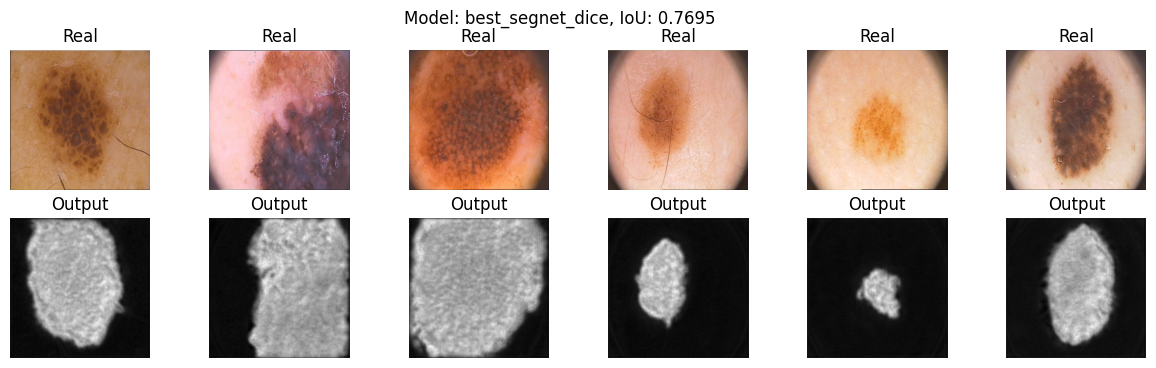

0.7695


In [ ]:
print_result(segnet_dice_model, seg_dice_name, test_dataloader, device, seg_dice_test_iou)

In [ ]:
result_dict['segnet_dice'] = (seg_dice_test_iou, seg_dice_times, seg_dice_losses)

#### SegNet: Focal Loss

In [ ]:
segnet_focal_model = SegNet().to(device)

In [ ]:
optim = torch.optim.Adam(segnet_focal_model.parameters(), lr=1e-3)
seg_focal_name = "best_segnet_focal_model.pth"
seg_focal_times, seg_focal_losses = train(seg_focal_name, segnet_focal_model, train_dataloader, valid_dataloader, max_epochs, device, focal_loss, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.0973, IoU: 0.0000, Time: 4.41s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.0568, IoU: 0.0000, Time: 4.40s
Saved best model with IoU: 0.0000


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.0511, IoU: 0.0000, Time: 4.42s
Saved best model with IoU: 0.0000


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.0481, IoU: 0.0000, Time: 4.44s


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.0444, IoU: 0.0517, Time: 4.46s
Saved best model with IoU: 0.0517


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.0380, IoU: 0.1660, Time: 4.47s
Saved best model with IoU: 0.1660


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.0331, IoU: 0.2690, Time: 4.43s
Saved best model with IoU: 0.2690


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.0314, IoU: 0.2309, Time: 4.44s


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.0318, IoU: 0.2056, Time: 4.39s


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.0308, IoU: 0.3214, Time: 4.35s
Saved best model with IoU: 0.3214


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.0301, IoU: 0.5809, Time: 4.35s
Saved best model with IoU: 0.5809


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.0285, IoU: 0.2837, Time: 4.37s


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.0255, IoU: 0.5079, Time: 4.36s


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.0249, IoU: 0.0000, Time: 4.38s


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.0253, IoU: 0.0000, Time: 4.38s


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.0249, IoU: 0.0000, Time: 4.40s


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.0259, IoU: 0.0000, Time: 4.42s


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.0218, IoU: 0.0000, Time: 4.42s


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.0254, IoU: 0.3267, Time: 4.43s


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.0211, IoU: 0.0002, Time: 4.46s


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.0248, IoU: 0.4336, Time: 4.42s


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.0221, IoU: 0.7482, Time: 4.42s
Saved best model with IoU: 0.7482


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.0237, IoU: 0.6859, Time: 4.42s


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.0196, IoU: 0.6464, Time: 4.41s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.0202, IoU: 0.6563, Time: 4.44s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.0187, IoU: 0.7433, Time: 4.41s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.0177, IoU: 0.7678, Time: 4.42s
Saved best model with IoU: 0.7678


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.0189, IoU: 0.7774, Time: 4.40s
Saved best model with IoU: 0.7774


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.0199, IoU: 0.7825, Time: 4.44s
Saved best model with IoU: 0.7825


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.0207, IoU: 0.7831, Time: 4.39s
Saved best model with IoU: 0.7831


In [ ]:
segnet_focal_model.load_state_dict(torch.load(f"./weights/{seg_focal_name}"))

<All keys matched successfully>

In [ ]:
seg_focal_test_iou = test(segnet_focal_model, test_dataloader, device)

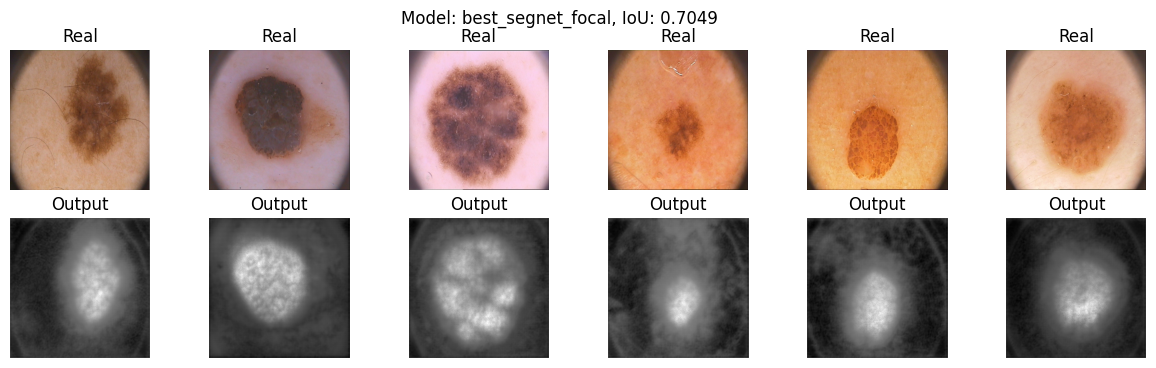

0.7049


In [ ]:
print_result(segnet_focal_model, seg_focal_name, test_dataloader, device, seg_focal_test_iou)

In [ ]:
result_dict['segnet_focal'] = (seg_focal_test_iou, seg_focal_times, seg_focal_losses)

#### SegNet: Tversky loss

In [ ]:
segnet_tversky_model = SegNet().to(device)

In [ ]:
optim = torch.optim.Adam(segnet_tversky_model.parameters(), lr=1e-3)
seg_tversky_name = "best_segnet_tversky_model.pth"
seg_tversky_times, seg_tversky_losses = train(seg_tversky_name, segnet_tversky_model, train_dataloader, valid_dataloader, max_epochs, device, tversky_loss, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.5665, IoU: 0.0000, Time: 4.63s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.4650, IoU: 0.3296, Time: 4.30s
Saved best model with IoU: 0.3296


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.3552, IoU: 0.3427, Time: 4.31s
Saved best model with IoU: 0.3427


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.3017, IoU: 0.2952, Time: 4.34s


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.2639, IoU: 0.3575, Time: 4.45s
Saved best model with IoU: 0.3575


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.2422, IoU: 0.1518, Time: 4.48s


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.2202, IoU: 0.5015, Time: 4.49s
Saved best model with IoU: 0.5015


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.1898, IoU: 0.5263, Time: 4.57s
Saved best model with IoU: 0.5263


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.1693, IoU: 0.6143, Time: 4.59s
Saved best model with IoU: 0.6143


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.1378, IoU: 0.6449, Time: 4.57s
Saved best model with IoU: 0.6449


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.1291, IoU: 0.6778, Time: 4.52s
Saved best model with IoU: 0.6778


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.1265, IoU: 0.6650, Time: 4.47s


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.1158, IoU: 0.6480, Time: 4.45s


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.1053, IoU: 0.6601, Time: 4.45s


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.1061, IoU: 0.6941, Time: 4.40s
Saved best model with IoU: 0.6941


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.1032, IoU: 0.7449, Time: 4.37s
Saved best model with IoU: 0.7449


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.0913, IoU: 0.7394, Time: 4.37s


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.0998, IoU: 0.7458, Time: 4.37s
Saved best model with IoU: 0.7458


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.1144, IoU: 0.7703, Time: 4.38s
Saved best model with IoU: 0.7703


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.0995, IoU: 0.5985, Time: 4.39s


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.0994, IoU: 0.7393, Time: 4.41s


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.0961, IoU: 0.7473, Time: 4.45s


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.0965, IoU: 0.7185, Time: 4.45s


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.0938, IoU: 0.6667, Time: 4.47s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.0832, IoU: 0.7192, Time: 4.47s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.0766, IoU: 0.7242, Time: 4.49s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.0717, IoU: 0.7207, Time: 4.54s


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.0706, IoU: 0.7270, Time: 4.48s


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.0625, IoU: 0.7322, Time: 4.47s


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.0706, IoU: 0.6965, Time: 4.44s


In [ ]:
segnet_tversky_model.load_state_dict(torch.load(f"./weights/{seg_tversky_name}"))

<All keys matched successfully>

In [ ]:
seg_tversky_test_iou = test(segnet_tversky_model, test_dataloader, device)

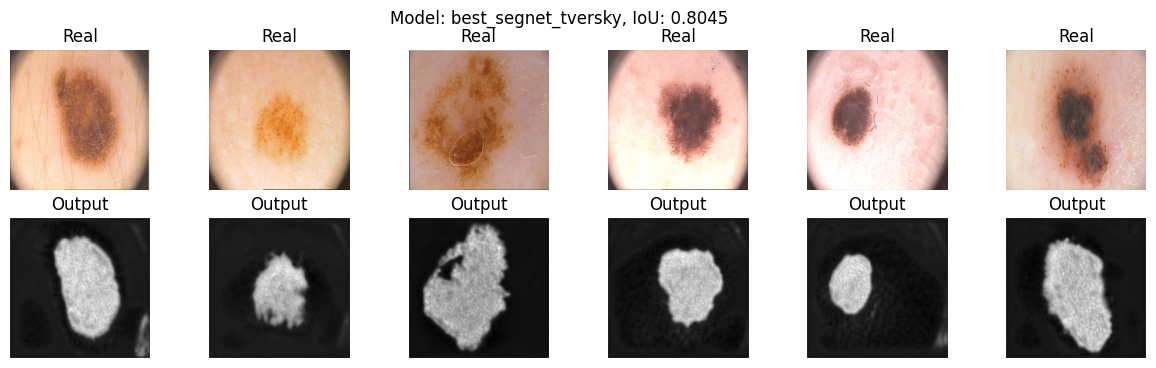

0.8045


In [ ]:
print_result(segnet_tversky_model, seg_tversky_name, test_dataloader, device, seg_tversky_test_iou)

In [ ]:
result_dict['segnet_tversky'] = (seg_tversky_test_iou, seg_tversky_times, seg_tversky_losses)

Сохраним данные в словарь

In [ ]:
import pickle
with open('train_log.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

#### Ответы на вопросы

In [ ]:
import pandas as pd

def print_losses(rd):
    all_losses = []
    labels = []

    for k, v in rd.items():
        labels.append(k)
        all_losses.append(v[2])

    plt.figure(figsize=(10, 8))

    # Plot each set of losses
    for losses, label in zip(all_losses, labels):
        # new_loses = []
        # for loss in losses:

          # if isinstance(loss, torch.Tensor):
          #    loss = loss.cpu().detach().numpy()
          #    new_loses.append(loss)

        plt.plot(range(1, max_epochs + 1), losses, label=label)

    plt.title('Сравнение Loss моделей в зависимости от эпох')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(title='Model', loc='upper right')
    plt.grid()
    plt.show()

def create_table(rd):
    model_names = [k for k in rd.keys()]

    scores = [v[0] for v in rd.values()]
    tr_times = [sum(v[1]) for v in rd.values()]

    df = pd.DataFrame({'score': scores, 'training_time': tr_times}, index=model_names)
    df.sort_values(by='score', ascending=False, inplace=True)
    return df

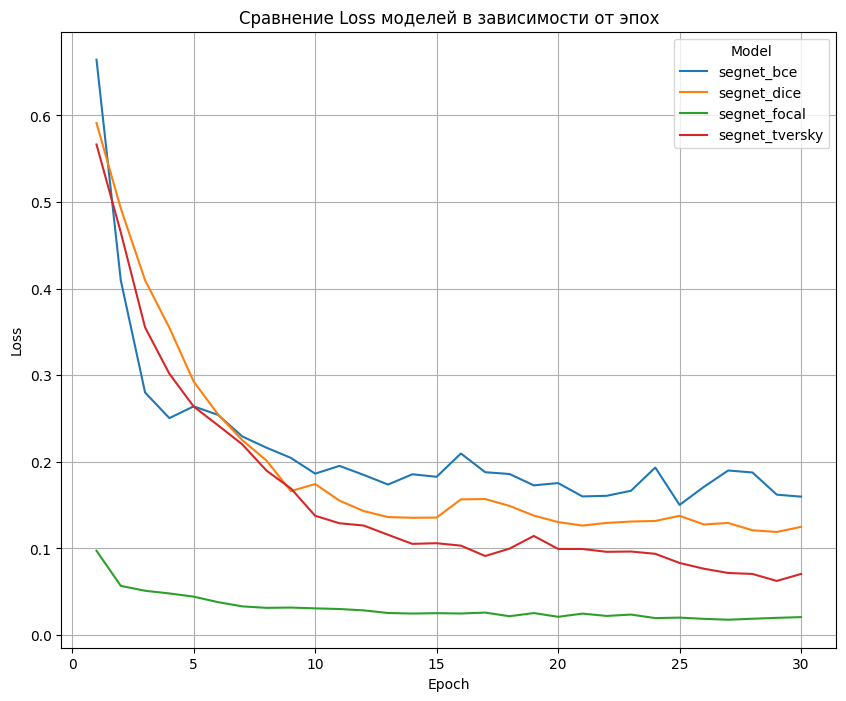

In [ ]:
print_losses(result_dict)

In [ ]:
res_df = create_table(result_dict)
res_df

score  training_time
segnet_tversky  0.804503     133.586417
segnet_bce      0.794285     127.438836
segnet_dice     0.769529     132.762578
segnet_focal    0.704921     132.334061

* Быстрее всего модель сошлась при **Focal Loss**
* **SegNet с Tversky Loss** выдает лучшую метрику: **0.8**

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

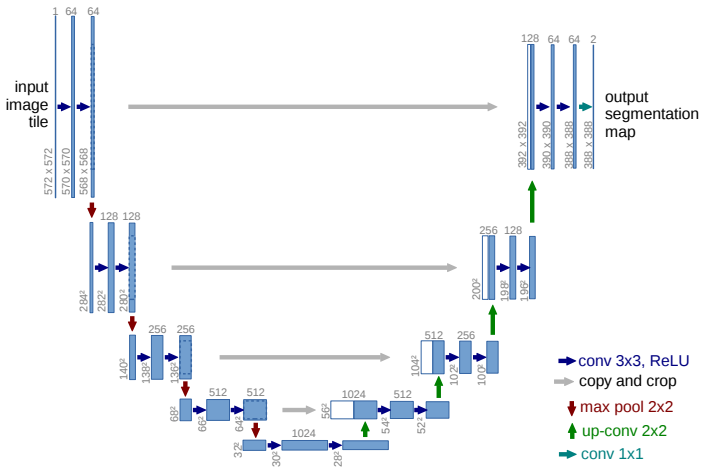

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(3, 2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(3, 2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        #print(e0.size())
        e1 = self.pool1(self.enc_conv1(e0))
        #print(e1.size())
        e2 = self.pool2(self.enc_conv2(e1))
        #print(e2.size())
        e3 = self.pool3(self.enc_conv3(e2))
        #print(e3.size())

        # bottleneck
        b = self.bottleneck_conv(e3)
        #print(b.size())

        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.concat([e3, b], 1)))
        #print(d0.size())
        d1 = self.dec_conv1(self.upsample1(torch.concat([e2, d0], 1)))
        #print(d1.size())
        d2 = self.dec_conv2(self.upsample2(torch.concat([e1, d1], 1)))
        #print(d2.size())
        d3 = self.dec_conv3(self.upsample3(torch.concat([e0, d2], 1)))
        #print(d3.size())  # no activation
        return d3


## Обучите UNet

#### UNet: BCE Loss

In [ ]:
unet_bce_model = UNet().to(device)

In [ ]:
optim = torch.optim.Adam(unet_bce_model.parameters(), lr=1e-3)
unet_bce_name = "best_unet_bce_model.pth"
unet_bce_times, unet_bce_losses = train(unet_bce_name, unet_bce_model, train_dataloader, valid_dataloader, max_epochs, device, bce_loss_stable, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.5955, IoU: 0.0000, Time: 4.78s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.4373, IoU: 0.0000, Time: 4.63s
Saved best model with IoU: 0.0000


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.4196, IoU: 0.0000, Time: 4.70s
Saved best model with IoU: 0.0000


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.4078, IoU: 0.0000, Time: 4.75s


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.3975, IoU: 0.0000, Time: 4.81s
Saved best model with IoU: 0.0000


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.3976, IoU: 0.0615, Time: 4.92s
Saved best model with IoU: 0.0615


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.3929, IoU: 0.2827, Time: 4.94s
Saved best model with IoU: 0.2827


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.3997, IoU: 0.4008, Time: 4.90s
Saved best model with IoU: 0.4008


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.3879, IoU: 0.4450, Time: 4.84s
Saved best model with IoU: 0.4450


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.3781, IoU: 0.6625, Time: 4.81s
Saved best model with IoU: 0.6625


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.3706, IoU: 0.7099, Time: 4.77s
Saved best model with IoU: 0.7099


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.3715, IoU: 0.7210, Time: 4.74s
Saved best model with IoU: 0.7210


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.3690, IoU: 0.7495, Time: 4.70s
Saved best model with IoU: 0.7495


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.3714, IoU: 0.7669, Time: 4.70s
Saved best model with IoU: 0.7669


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.3606, IoU: 0.7807, Time: 4.70s
Saved best model with IoU: 0.7807


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.3606, IoU: 0.7743, Time: 4.90s


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.3560, IoU: 0.7991, Time: 4.85s
Saved best model with IoU: 0.7991


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.3493, IoU: 0.7939, Time: 4.89s


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.3555, IoU: 0.8077, Time: 4.78s
Saved best model with IoU: 0.8077


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.3470, IoU: 0.7682, Time: 4.81s


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.3506, IoU: 0.7860, Time: 4.78s


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.3492, IoU: 0.7838, Time: 4.78s


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.3485, IoU: 0.8095, Time: 4.78s
Saved best model with IoU: 0.8095


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.3386, IoU: 0.7886, Time: 4.77s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.3348, IoU: 0.7969, Time: 4.78s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.3336, IoU: 0.8036, Time: 4.74s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.3298, IoU: 0.7671, Time: 4.75s


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.3353, IoU: 0.8047, Time: 4.74s


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.3391, IoU: 0.7700, Time: 4.75s


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.3285, IoU: 0.7601, Time: 4.74s


In [ ]:
unet_bce_model.load_state_dict(torch.load(f"./weights/{unet_bce_name}"))

<All keys matched successfully>

In [ ]:
unet_bce_test_iou = test(unet_bce_model, test_dataloader, device)

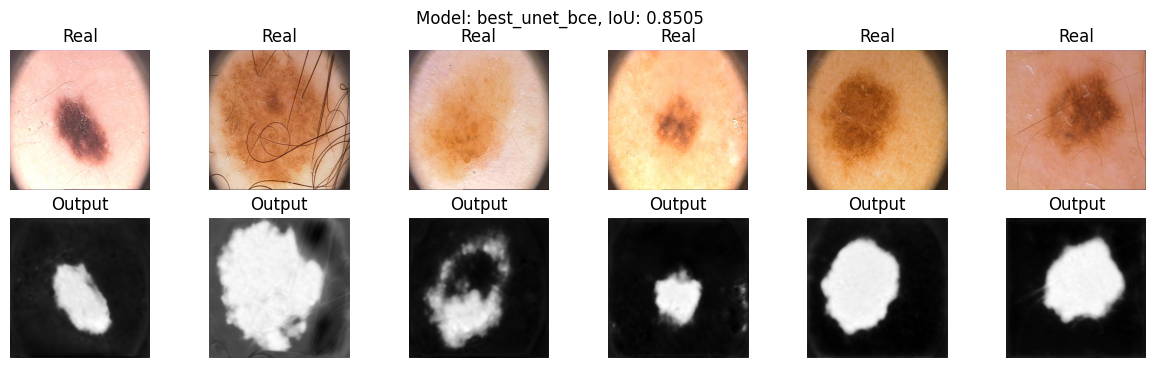

0.8505


In [ ]:
print_result(unet_bce_model, unet_bce_name, test_dataloader, device, unet_bce_test_iou)

In [ ]:
result_dict['unet_bce'] = (unet_bce_test_iou, unet_bce_times, unet_bce_losses)

In [ ]:
import pickle
with open('train_log.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

#### UNet: Dice Loss

In [ ]:
unet_dice_model = UNet().to(device)

In [ ]:
optim = torch.optim.Adam(unet_dice_model.parameters(), lr=1e-3)
unet_dice_name = "best_unet_dice_model.pth"
unet_dice_times, unet_dice_losses = train(unet_dice_name, unet_dice_model, train_dataloader, valid_dataloader, max_epochs, device, dice_loss, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.4807, IoU: 0.0000, Time: 4.74s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.4145, IoU: 0.0000, Time: 4.74s


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.3971, IoU: 0.0274, Time: 4.85s
Saved best model with IoU: 0.0274


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.3917, IoU: 0.5537, Time: 4.93s
Saved best model with IoU: 0.5537


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.3800, IoU: 0.5294, Time: 5.11s


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.3792, IoU: 0.4776, Time: 4.92s


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.3739, IoU: 0.4913, Time: 4.84s


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.3722, IoU: 0.4534, Time: 4.80s


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.3701, IoU: 0.5091, Time: 4.82s


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.3644, IoU: 0.6645, Time: 4.74s
Saved best model with IoU: 0.6645


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.3619, IoU: 0.6714, Time: 4.74s
Saved best model with IoU: 0.6714


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.3615, IoU: 0.6972, Time: 4.70s
Saved best model with IoU: 0.6972


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.3597, IoU: 0.7516, Time: 4.67s
Saved best model with IoU: 0.7516


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.3632, IoU: 0.7521, Time: 4.87s
Saved best model with IoU: 0.7521


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.3652, IoU: 0.7574, Time: 4.75s
Saved best model with IoU: 0.7574


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.3639, IoU: 0.7410, Time: 4.77s


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.3566, IoU: 0.7695, Time: 4.73s
Saved best model with IoU: 0.7695


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.3543, IoU: 0.7549, Time: 4.79s


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.3487, IoU: 0.7686, Time: 4.79s


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.3533, IoU: 0.7866, Time: 4.80s
Saved best model with IoU: 0.7866


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.3499, IoU: 0.8062, Time: 4.78s
Saved best model with IoU: 0.8062


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.3487, IoU: 0.7793, Time: 4.80s


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.3605, IoU: 0.7710, Time: 4.76s


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.3518, IoU: 0.7600, Time: 4.75s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.3483, IoU: 0.7668, Time: 4.73s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.3532, IoU: 0.7891, Time: 4.74s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.3457, IoU: 0.7700, Time: 4.76s


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.3488, IoU: 0.7674, Time: 4.71s


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.3445, IoU: 0.7894, Time: 4.74s


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.3435, IoU: 0.8001, Time: 4.70s


In [ ]:
unet_dice_model.load_state_dict(torch.load(f"./weights/{unet_dice_name}"))

<All keys matched successfully>

In [ ]:
unet_dice_test_iou = test(unet_dice_model, test_dataloader, device)

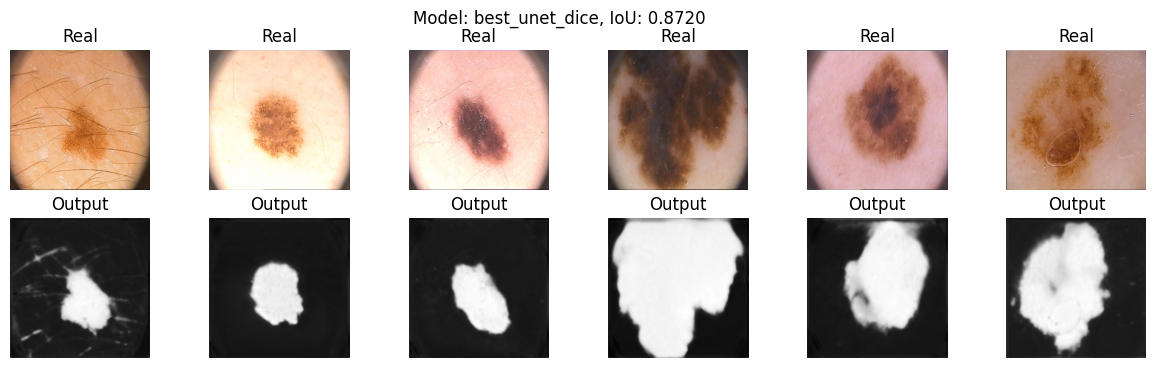

0.8720


In [ ]:
print_result(unet_dice_model, unet_dice_name, test_dataloader, device, unet_dice_test_iou)

In [ ]:
result_dict['unet_dice'] = (unet_dice_test_iou, unet_dice_times, unet_dice_losses)

In [ ]:
import pickle
with open('train_log.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

#### UNet: Focal Loss

In [ ]:
unet_focal_model = UNet().to(device)

In [ ]:
optim = torch.optim.Adam(unet_focal_model.parameters(), lr=1e-3)
unet_focal_name = "best_unet_focal_model.pth"
unet_focal_times, unet_focal_losses = train(unet_focal_name, unet_focal_model, train_dataloader, valid_dataloader, max_epochs, device, focal_loss, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.1100, IoU: 0.0000, Time: 4.73s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.0470, IoU: 0.0000, Time: 4.75s


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.0432, IoU: 0.0000, Time: 4.83s


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.0391, IoU: 0.0000, Time: 4.89s


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.0380, IoU: 0.0131, Time: 4.98s
Saved best model with IoU: 0.0131


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.0374, IoU: 0.0321, Time: 4.97s
Saved best model with IoU: 0.0321


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.0351, IoU: 0.2627, Time: 4.87s
Saved best model with IoU: 0.2627


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.0367, IoU: 0.2085, Time: 4.82s


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.0362, IoU: 0.5186, Time: 4.79s
Saved best model with IoU: 0.5186


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.0331, IoU: 0.4313, Time: 4.76s


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.0309, IoU: 0.5265, Time: 4.72s
Saved best model with IoU: 0.5265


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.0359, IoU: 0.5435, Time: 4.75s
Saved best model with IoU: 0.5435


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.0317, IoU: 0.6166, Time: 4.73s
Saved best model with IoU: 0.6166


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.0328, IoU: 0.7116, Time: 4.71s
Saved best model with IoU: 0.7116


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.0316, IoU: 0.7347, Time: 4.72s
Saved best model with IoU: 0.7347


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.0307, IoU: 0.7232, Time: 4.74s


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.0309, IoU: 0.7101, Time: 4.77s


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.0301, IoU: 0.7263, Time: 4.76s


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.0288, IoU: 0.7560, Time: 4.79s
Saved best model with IoU: 0.7560


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.0289, IoU: 0.7239, Time: 4.80s


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.0307, IoU: 0.7685, Time: 4.80s
Saved best model with IoU: 0.7685


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.0292, IoU: 0.7007, Time: 4.78s


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.0290, IoU: 0.6748, Time: 4.79s


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.0274, IoU: 0.7588, Time: 4.79s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.0274, IoU: 0.7677, Time: 4.77s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.0272, IoU: 0.7572, Time: 4.79s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.0279, IoU: 0.7710, Time: 4.74s
Saved best model with IoU: 0.7710


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.0266, IoU: 0.7690, Time: 4.76s


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.0258, IoU: 0.7507, Time: 4.73s


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.0251, IoU: 0.7749, Time: 4.77s
Saved best model with IoU: 0.7749


In [ ]:
unet_focal_model.load_state_dict(torch.load(f"./weights/{unet_focal_name}"))

<All keys matched successfully>

In [ ]:
unet_focal_test_iou = test(unet_focal_model, test_dataloader, device)

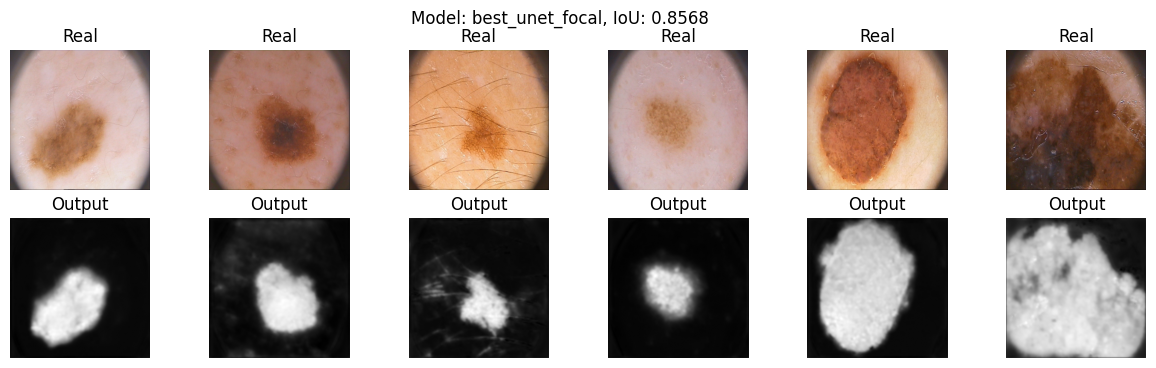

0.8568


In [ ]:
print_result(unet_focal_model, unet_focal_name, test_dataloader, device, unet_focal_test_iou)

In [ ]:
result_dict['unet_focal'] = (unet_focal_test_iou, unet_focal_times, unet_focal_losses)

In [ ]:
import pickle
with open('train_log.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

#### UNet: Tversky loss

In [ ]:
unet_tversky_model = UNet().to(device)

In [ ]:
optim = torch.optim.Adam(unet_tversky_model.parameters(), lr=1e-3)
unet_tversky_name = "best_unet_tversky_model.pth"
unet_tversky_times, unet_tversky_losses = train(unet_tversky_name, unet_tversky_model, train_dataloader, valid_dataloader, max_epochs, device, tversky_loss, optim)

Epoch 1/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.4285, IoU: 0.0000, Time: 4.71s
Saved best model with IoU: 0.0000


Epoch 2/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.3616, IoU: 0.0000, Time: 4.72s
Saved best model with IoU: 0.0000


Epoch 3/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.3426, IoU: 0.0140, Time: 4.79s
Saved best model with IoU: 0.0140


Epoch 4/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.3335, IoU: 0.2301, Time: 4.90s
Saved best model with IoU: 0.2301


Epoch 5/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.3248, IoU: 0.3392, Time: 4.95s
Saved best model with IoU: 0.3392


Epoch 6/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.3217, IoU: 0.3356, Time: 4.98s


Epoch 7/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.3272, IoU: 0.3586, Time: 4.91s
Saved best model with IoU: 0.3586


Epoch 8/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.3265, IoU: 0.3859, Time: 4.83s
Saved best model with IoU: 0.3859


Epoch 9/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.3115, IoU: 0.5192, Time: 4.79s
Saved best model with IoU: 0.5192


Epoch 10/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.3229, IoU: 0.6929, Time: 4.75s
Saved best model with IoU: 0.6929


Epoch 11/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.3183, IoU: 0.6219, Time: 4.75s


Epoch 12/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.3114, IoU: 0.5534, Time: 4.69s


Epoch 13/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.3092, IoU: 0.6066, Time: 4.69s


Epoch 14/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.3105, IoU: 0.7276, Time: 4.68s
Saved best model with IoU: 0.7276


Epoch 15/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.3051, IoU: 0.7525, Time: 4.76s
Saved best model with IoU: 0.7525


Epoch 16/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.3072, IoU: 0.7358, Time: 4.74s


Epoch 17/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.3024, IoU: 0.7277, Time: 4.75s


Epoch 18/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.3051, IoU: 0.6593, Time: 4.75s


Epoch 19/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.2979, IoU: 0.7068, Time: 4.79s


Epoch 20/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.3009, IoU: 0.7390, Time: 4.80s


Epoch 21/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.2980, IoU: 0.7203, Time: 4.81s


Epoch 22/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.2965, IoU: 0.7995, Time: 4.79s
Saved best model with IoU: 0.7995


Epoch 23/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.3048, IoU: 0.7263, Time: 4.79s


Epoch 24/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.2996, IoU: 0.6887, Time: 4.77s


Epoch 25/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.3021, IoU: 0.6725, Time: 4.74s


Epoch 26/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.2993, IoU: 0.6488, Time: 4.76s


Epoch 27/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.2918, IoU: 0.6769, Time: 4.74s


Epoch 28/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.3000, IoU: 0.7319, Time: 4.77s


Epoch 29/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.2897, IoU: 0.7030, Time: 4.75s


Epoch 30/30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.2936, IoU: 0.7697, Time: 4.75s


In [ ]:
unet_tversky_model.load_state_dict(torch.load(f"./weights/{unet_tversky_name}"))

<All keys matched successfully>

In [ ]:
unet_tversky_test_iou = test(unet_tversky_model, test_dataloader, device)

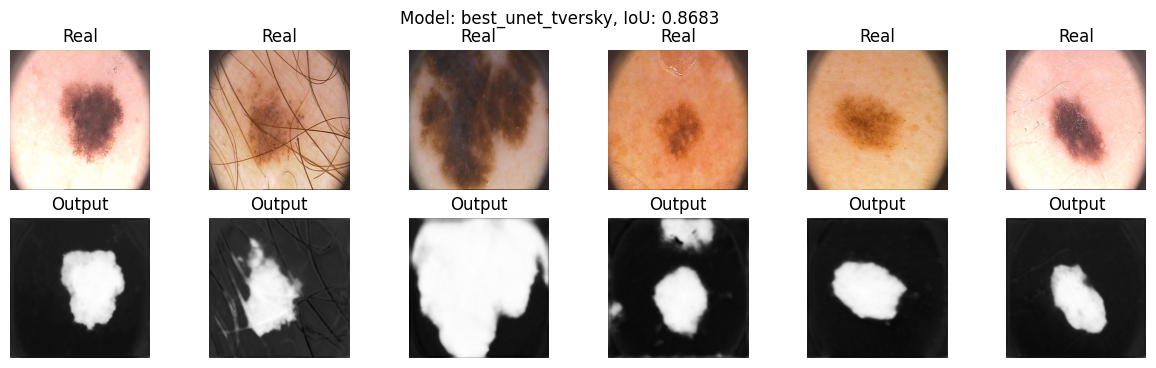

0.8683


In [ ]:
print_result(unet_tversky_model, unet_tversky_name, test_dataloader, device, unet_tversky_test_iou)

In [ ]:
result_dict['unet_tversky'] = (unet_tversky_test_iou, unet_tversky_times, unet_tversky_losses)

Сохраним данные:

In [ ]:
import pickle
with open('train_log.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

Загрузим данные:

In [ ]:
with open('train_log.pkl', 'rb') as f:
    result_dict = pickle.load(f)

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



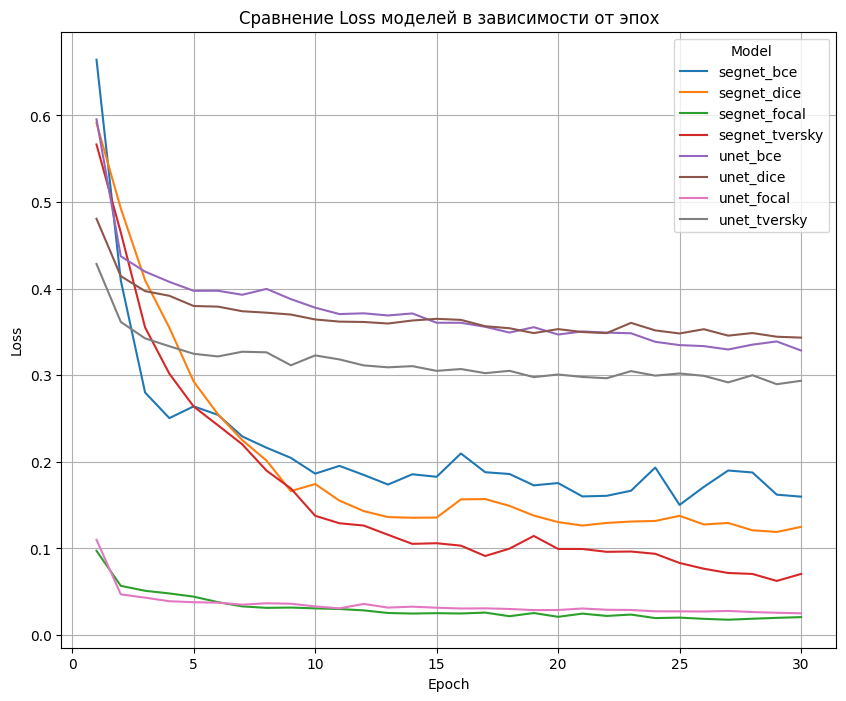

In [ ]:
print_losses(result_dict)

In [ ]:
res2_df = create_table(result_dict)
res2_df

score  training_time
unet_dice       0.872043     143.563288
unet_tversky    0.868302     143.379406
unet_focal      0.856788     143.633758
unet_bce        0.850518     143.527555
segnet_tversky  0.804503     133.586417
segnet_bce      0.794285     127.438836
segnet_dice     0.769529     132.762578
segnet_focal    0.704921     132.334061

#### Вывод

Для UNet и SegNet примерно одинаково по времени сходятся Focal Loss. Что-то в районе 5 эпох. Далее идут Dice, Tversky, BCE - они примерно сходятся одинаково по скорости.

* Для SegNet получилось, что наиболее высокое качество **SegNet - Tversky, 0.80**.

* Для UnetNet получилось, что наиболее высокое качество **UNet - Dice, 0.87**.

* Самая лучшая модель по значениям метрики: **UNet - Dice, 0.87**.

Если резюмировать суммарно, то лучше всего на всех Loss функциях показала себя модель UNet. Кроме того, помимо итогового качества, UNet обучается даже быстрее чем SegNet, что подтверждают данные из таблицы.

---